# Entrenamiento para detectar caídas
## Importaciones

In [13]:
import cv2
import numpy as np
import os
from pose_estimation import PoseEstimation
import pandas

## Constantes

In [14]:
videos_path = "videos/"
expected_pixels = 257
frame_rate = 5
body_parts = ["nose", "leftEye", "rightEye", "leftEar", "rightEar", "leftShoulder", "rightShoulder",
                  "leftElbow", "rightElbow", "leftWrist", "rightWrist", "leftHip", "rightHip", "leftKnee",
                  "rightKnee", "leftAnkle", "rightAnkle"]



In [15]:
def make_square(img, expected_pixels):
    max_side = max(img.shape[0:2])

    # Background square
    square_img = np.zeros((max_side, max_side, 3), np.uint8)

    # Getting the centering position
    ax, ay = (max_side - img.shape[1]) // 2, (max_side - img.shape[0]) // 2

    # Pasting the image in a centering position
    square_img[ay:img.shape[0] + ay, ax:ax + img.shape[1]] = img

    return cv2.resize(square_img, (expected_pixels, expected_pixels))

## Preprocesamiento
#### En primer lugar abrimos el directorio donde se encuentran los vídeos, es importante que en esta carpeta (videos) solo hayan carpetas que contengan vídeos de 3 segundos
Se extraen las diferentes partes del cuerpo del modelo Posenet y se normalizan los datos.

La entrada del algoritmo de aprendizaje será así:

- Frame0_nose_X,Frame0_nose_Y,…,Frame[i]_[keypoint_j]_X, Frame[i]_[keypoint_j]_Y,…,[resultado].
Siéndo [i] el número de frame, [keypoint_j] la parte del cuerpo y [resultado] el estado al que corresponden los datos.


Donde cada línea es un vídeo.

In [16]:
# Cogemos el nombre de las clases (los estados) de las carpetas que contienen los vídeos
class_names = [x[0].split("/")[1] for x in os.walk(videos_path)][1:]
data = None
pe = PoseEstimation()
for class_name in class_names:
    videos = [x[2] for x in os.walk("{}{}".format(videos_path, class_name))][0]
    for file in videos:
        video_data = None
        video = cv2.VideoCapture("{}{}/{}".format(videos_path, class_name, file))
        video_rate = int(np.round(video.get(cv2.CAP_PROP_FPS) / frame_rate))
        while video.isOpened():
            frame_number = video.get(1) # current frame number
            ret, frame = video.read()
            if not ret: break
            if frame_number % video_rate == 0:
                frame = make_square(frame, pe.expected_pixels)
                pose = pe.get_pose_estimation(frame)

                # Normalizing position
                #average_x = np.mean(pose[:, 0])
                #average_y = np.mean(pose[:, 1])
                #pose[:, 0] = pose[:, 0] - average_x
                #pose[:, 1] = pose[:, 1] - average_y

                # Normalizing scale
                max_val = np.max(np.abs(pose))
                pose[:] = pose[:] / max_val

                pose = pose.reshape(-1)
                if video_data is None:
                    video_data = pose
                else:
                    video_data = np.hstack((video_data, pose))
        video.release()
        video_data = np.append(video_data, class_name)
        if data is None:
            data = video_data
        else:
            data = np.vstack((data, video_data))

Ponemos nombre a las cabeceras y guardamos los resultados en un archivo .csv

In [17]:
header = None

body_parts_len = len(body_parts)
data_len = len(data[0]) -1
elements_per_part = 2 #  porque cada parte del cuerpo tiene X e Y
frame = -1
for i in range(0, data_len, elements_per_part):
    if i % body_parts_len == 0:
        frame += 1
    body_part = body_parts[int(i/elements_per_part)%body_parts_len]
    title = "Frame_{}_{}".format(frame, body_part)
    if header is None:
        header = "{}_X".format(title)
    else:
        header = np.hstack((header, "{}_X".format(title)))
    header = np.hstack((header, "{}_Y".format(title)))
    #header = np.hstack((header, "{}_Reliable".format(title)))
header = np.hstack((header, "class"))

pandas.DataFrame(data).to_csv("data/data.csv", header=header, index=False)

## Entrenamiento
Creamos el set de validación

In [18]:
from sklearn.model_selection import train_test_split

data = pandas.read_csv("data/data.csv")
y = data[:]['class']
data = data.iloc[: , :-1]
x_train, x_test, y_train, y_test = train_test_split(data, y, random_state=42, test_size=0.2)

### Aplicamos un algoritmo de aprendizaje
[RandomForestClassifier]

In [19]:
from sklearn.ensemble import RandomForestClassifier
base_model = RandomForestClassifier()
base_model.fit(x_train, y_train)

RandomForestClassifier()

## Guardamos el modelo

In [20]:
import pickle
pickle.dump(base_model, open("model/fall_detection.sav", 'wb'))

## Cargamos el modelo

In [21]:
import pickle
base_model = pickle.load(open("model/fall_detection.sav", 'rb'))

Realizamos pruebas con el modelo

Random Forest Classifier report 
               precision    recall  f1-score   support

        Fall       0.89      0.89      0.89         9
     Nothing       1.00      0.89      0.94         9
     Recover       0.86      1.00      0.92         6

    accuracy                           0.92        24
   macro avg       0.92      0.93      0.92        24
weighted avg       0.92      0.92      0.92        24



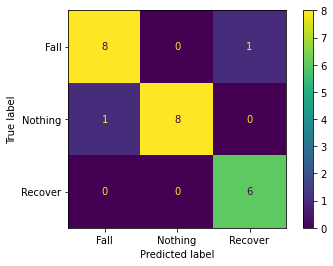

In [22]:
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix

y_pred = base_model.predict(x_test)
print("Random Forest Classifier report \n", classification_report(y_test, y_pred))
print(plot_confusion_matrix(base_model, x_test, y_test, display_labels=class_names))